## Context
A patient with a brain tumor requires therapeutic treatment for a period of time. He must undergo a MRI examination every 4 months to follow the evolution of the tumor. One important information for evaluating treatment is the change in tumor size between exams. <br>
Our purpose is to calculate the percentage change in tumor size between exams using FCM as a segmentation method.

## Data Exploration
Before implementing the FCM algorithm, let's first investigate our data and present some insights by plotting the images and their corresponding histograms :

In [1]:
import numpy as np
from scipy.ndimage import label, generate_binary_structure
from scipy import ndimage
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import random
%matplotlib inline 

Image 1 : 


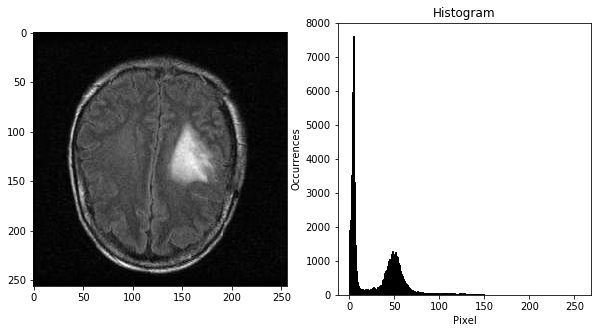

Image 2 : 


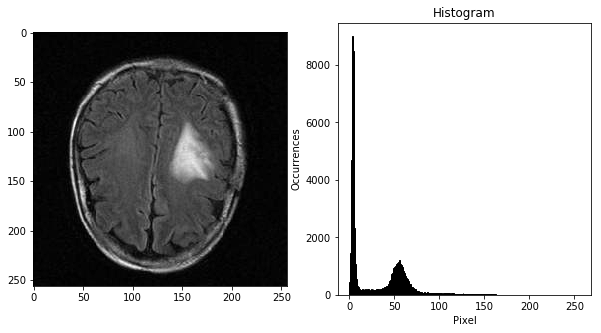

In [2]:
# read images and convert them to matrices
def image_to_array(image) :
    X = Image.open(image).convert("L")
    img = np.asarray(X)
    return img

# plot images and their histograms
def plot(img):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(img, cmap=plt.cm.gray)
    ax[1].hist(img.ravel(), bins=256, range=(0.0, 256), fc='k', ec='k')
    ax[1].set(title = "Histogram")
    ax[1].set(xlabel = "Pixel")
    ax[1].set(ylabel = "Occurrences")
    plt.show()
    
# List of images 
IMAGES = [ "../Data/IRMcoupe17-t1.jpg", "../Data/IRMcoupe17-t2.jpg"]

for i, image in enumerate(IMAGES):
    print("Image " + str(i+1) + " : ")
    img = image_to_array(image)
    plot(img)

As we can see, there are three main regions : the brain, the background and the tumor. By observing the histogram, one can segment *manually* the image by specifying two thresholds. For instance, let's choose $T_1 = 25$ and $T_2 = 80$. By doing so, we created three regions : the pixels less than $T_1$, the pixels lying between $T_1$ and $T_2$ and the ones greater than $T_2$.<br>
Let's display the three regions according to the previous thresholds :

Image 1 : 


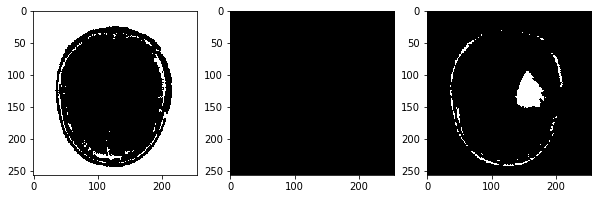

Image 2 : 


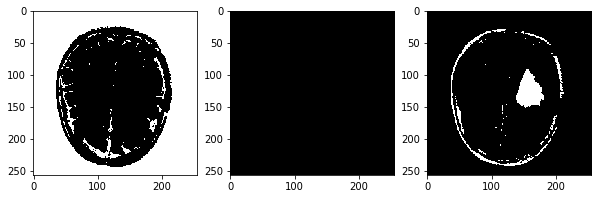

In [3]:
# Choosing manually the thresholds
T1, T2 = 25, 80

# Thresholding the images
for i, image in enumerate(IMAGES):
    print("Image " + str(i+1) + " : ")
    img = image_to_array(image)
    img1 = img < T1
    img2 = img > T1
    img2 = img2 < T2
    img3 = img > T2
    fig, ax = plt.subplots(1, 3, figsize=(10, 5))
    ax[0].imshow(img1, cmap='gray',  interpolation='nearest')
    ax[1].imshow(img2, cmap='gray',  interpolation='nearest')
    ax[2].imshow(img3, cmap='gray',  interpolation='nearest')
    plt.show()

Now we will perform this segmentation using machine learning and by applying the FCM algorithm.

# Image Segmentation using Fuzzy C-Means (FCM) Algorithm
Before implementing the *fuzzy c-means algorithm*, let's first describe its steps compared to our problem : <br>
1. Inputs : image ; K number of classes
2. Assign randomly to each pixel its degree of class affiliation
3. Repeat until convergence ( the objective function is $J = \sum_{i=1}^{K} \sum_{k=1}^{n} \mu_{ki}^m \| y_k - v_i\|^2 $) : <br>
Compute the centroids $v_i$ taking into account the degrees of class affiliation : <br>
$$ v_i = \frac{\sum_{k=1}^{n}\mu_{ki}^m y_k }{\sum_{k=1}^{n}\mu_{ki}^m} $$
Update for each pixel its degree of class affiliation :
$$ \mu_{ki} = \frac{1}{\sum_{j=1}^{K} (\frac{d_{ki}}{d_{kj}})^r} $$
$$ \text{With :  } r = \frac{2}{m - 1} \text{  and  } d_{ki} = \| y_k - v_i\| $$. 